In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy.visualization as vis

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from lsst.ip.diffim.detectAndMeasure import DetectAndMeasureTask, DetectAndMeasureConfig

In [2]:
# defines a few utilities we built in the last notebook..
def query_and_table(service, query):
    return service.search(query).to_table()


def table_summary(service, table_name: str):
    s = ""
    description = service.search(
        "SELECT description "
        "FROM tap_schema.tables "
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" 
        f"AND table_name = 'dp02_dc2_catalogs.{table_name}'"
    ).to_table().to_pandas().iloc[0]["description"]
    s += f"{table_name}: {description}\n\n"
    for i, row in service.search(
            "SELECT column_name, datatype, description, unit "
            "FROM tap_schema.columns "
            f"WHERE table_name = 'dp02_dc2_catalogs.{table_name}'"
        ).to_table().to_pandas().iterrows():
        s += f"{row.column_name}:  {row.description} ({row.datatype})\n"
    return s
        

def sregion_to_vertices(sregion: str, closed=True):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.

    from notebook DPO02_02c.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    if closed:
        xvertices.append(xvertices[0])
        yvertices.append(yvertices[0])
    return xvertices, yvertices


def circle_string(ra, dec, err_radius):
    return f"{ra:.4f}, {dec:.4f}, {err_radius:.4f}"


def query_obs_stdomain(service, tstart_mj, tstop_mj, ra, dec, err_radius, dp_subtype="lsst.calexp"):
    """
    Queries observation table for all pictures of type `dp_subtype` taken between 
    start_mj and stop_mj, with central spatial position falling in a circle centered
    at `ra`, `dec` with radius `err_radius`.
    """
    return query_and_table(
        service, 
        "SELECT *"
        "FROM ivoa.ObsCore "
        f"WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), CIRCLE('ICRS', {circle_string(ra, dec, err_radius)}))=1 "
        f"AND t_min >= {tstart_mj} "
        f"AND t_min < {tstop_mj} "
        f"AND dataproduct_subtype = '{dp_subtype}'"
    ).to_pandas()


service = get_tap_service("tap")

## In previous episodes: source injection and subtraction

In this section we recover some useful code and quantities we built in our notebook on source injection, 250508_injection.ipynb. In summary, we will define coordinate for a transient close to a nearby galaxy, inject the source and construct the image difference between the injected exposure and its template.

### Transient definition

In [3]:
coord_galhost = SkyCoord(
    ra = 56.922302 * u.degree, 
    dec = -33.948517 * u.degree,
)

In [4]:
coord_transient = SkyCoord(
    ra = coord_galhost.ra - 1.3 * u.arcmin,
    dec = coord_galhost.dec, 
    frame='icrs'
)
mag_transient = 17.

In [5]:
dataId = {
    "instrument": "LSSTCam-imSim",
    "detector": 60,
    "visit": 964209,
    "band": "r",
    "physical_filter": "r_sim_1.4",
}

butler = Butler('dp02', collections='2.2i/runs/DP0.2')
calexp = butler.get("calexp", dataId=dataId)

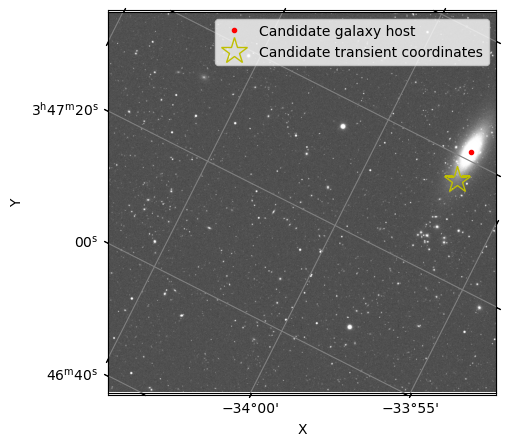

In [6]:
# plots the base image
img_wcs = WCS(calexp.getWcs().getFitsMetadata())
image_data = calexp.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Candidate galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

### Source injection

In [7]:
def inject_star_source(calexp, ra, dec, mag):
    EPSILON = 10**-7
    injection_catalog = generate_injection_catalog(
        ra_lim=[ra, ra + EPSILON],
        dec_lim=[dec, dec + EPSILON],
        number=1,
        source_type="Star",
        mag=[mag],
    )
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    injected_output = inject_task.run(
        injection_catalogs=injection_catalog,
        input_exposure=calexp.clone(),
        psf=calexp.getPsf(),
        photo_calib=calexp.getPhotoCalib(),
        wcs=calexp.getWcs(),
    )
    return injected_output.output_exposure, injected_output.output_catalog

calexp_injected, calexp_catalog = inject_star_source(calexp, coord_transient.ra.deg, coord_transient.dec.deg, mag_transient)

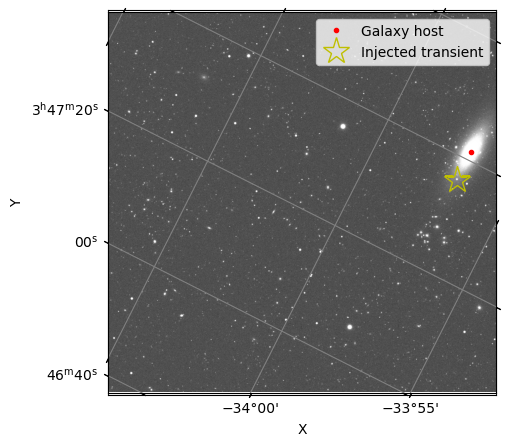

In [8]:
# plots the image with injected source
img_wcs = WCS(calexp_injected.getWcs().getFitsMetadata())
image_data = calexp_injected.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

### Image subtraction

In [9]:
sources = butler.get('src', dataId=dataId)
template = butler.get("goodSeeingDiff_templateExp", dataId=dataId)

config = AlardLuptonSubtractConfig()
config.sourceSelector.value.unresolved.name = 'base_ClassificationExtendedness_value'
alTask = AlardLuptonSubtractTask(config=config)
difference = alTask.run(template, calexp_injected, sources)
calexp_difference = difference.difference

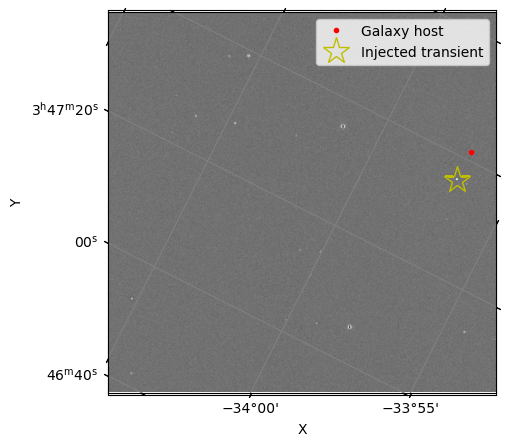

In [10]:
# plots the image difference
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

# Difference Image Analysis

The official tutorial notebook on source detection is weird. It does not work with difference images, so I'm wondering if we should be working with these at all. However, the `diffim` package from the LSST pipeline contains routines for source detection on difference image, see [this](https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/detectAndMeasure.py) page. They are scarcely documented but usable. Let's try to use it.

In [11]:
config = DetectAndMeasureConfig()
# the next line should select only positive sources but it's causing an error. maybe open an issue
# config.detection.thresholdPolarity = "positive"
results = DetectAndMeasureTask(config=config).run(calexp_injected, template, calexp_difference)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


This is an excerpt of what we got:

In [12]:
diaSources_lg_df = results.getDict()["diaSources"].asAstropy().to_pandas()
diaSources_lg_df.head()

,id,coord_ra,coord_dec,parent,coord_raErr,coord_decErr,coord_ra_dec_Cov,is_negative,detect_isPrimary,base_SdssCentroid_x,...,ip_diffim_forced_PsfFlux_instFlux,ip_diffim_forced_PsfFlux_instFluxErr,ip_diffim_forced_PsfFlux_area,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,refMatchId,srcMatchId,merge_footprint_positive,merge_footprint_negative
0,2,0.990230,-0.593444,0,1.677368e-07,2.116836e-07,2.202644e-15,False,False,1698.243285,...,2.124574e+05,691.254442,39.299316,False,False,False,0,0,True,False
1,3,0.991558,-0.591437,0,NaN,NaN,NaN,False,False,4051.014703,...,9.991358e+05,1471.714227,40.329296,True,False,True,0,0,True,True
2,4,0.989463,-0.594899,0,NaN,NaN,NaN,False,False,60.956102,...,1.288199e+06,1667.556451,39.479935,False,False,False,0,0,True,True
3,8,0.990936,-0.592827,0,2.626513e-07,3.219142e-07,1.931349e-15,False,False,2538.079052,...,1.473513e+03,234.013496,39.561100,False,False,False,0,0,True,False
4,11,0.991245,-0.593396,0,NaN,NaN,NaN,False,False,2127.223633,...,2.706309e+04,263.492992,39.505508,False,False,False,0,0,True,True


The table is huge and contains many columns of dubious value. Some of the column values needs conversion. We fix it and remove the anomalies with negative polarity.

In [44]:
_df = diaSources_lg_df
_d = {
    "is_negative": _df["is_negative"],
    "coord_ra": np.rad2deg(_df["coord_ra"]),
    "coord_dec": np.rad2deg(_df["coord_dec"]),
    "PsfFlux_base": _df["base_PsfFlux_instFlux"],
    "PsfFlux_baseErr": _df["base_PsfFlux_instFluxErr"],
    "PsfFlux_diffim": _df["ip_diffim_forced_PsfFlux_instFlux"],
    "PsfFlux_diffimErr": _df["ip_diffim_forced_PsfFlux_instFluxErr"],
    "snr_diffim": _df["ip_diffim_forced_PsfFlux_instFlux"] / _df["ip_diffim_forced_PsfFlux_instFluxErr"],
    "snr_base": _df["base_PsfFlux_instFlux"] / _df["base_PsfFlux_instFluxErr"],
}
diaSources_df = pd.DataFrame(_d).sort_values("snr_base", ascending=False)
# comment to keep negative sources
diaSources_df = diaSources_df[~diaSources_df["is_negative"]]
diaSources_df = diaSources_df.drop(columns=["is_negative"])

In [45]:
diaSources_df

,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base
11,56.900636,-33.948517,1.178504e+06,1584.213702,1.185265e+06,1586.573141,747.059760,743.904900
13,56.878835,-33.995991,8.855178e+04,2130.106379,2.065068e+06,2110.593033,978.430056,41.571530
10,56.900941,-33.942121,8.397084e+04,2203.335160,2.173672e+06,2181.495015,996.414082,38.110789
19,56.864645,-34.116765,2.862454e+04,2062.770567,1.932008e+06,2039.673386,947.214296,13.876746
0,56.735974,-34.001814,6.502495e+03,697.263449,2.124574e+05,691.254442,307.350570,9.325736
20,56.880746,-34.135867,2.311121e+03,250.189089,4.991528e+03,247.968260,20.129707,9.237498
18,56.891068,-34.033815,1.221150e+03,235.701101,1.205338e+03,232.321372,5.188237,5.180926
3,56.776472,-33.966500,1.195567e+03,235.841332,1.473513e+03,234.013496,6.296702,5.069371
8,56.848849,-34.007802,2.099256e+03,420.567637,6.366638e+04,415.907047,153.078399,4.991482
14,56.873320,-34.034913,3.706454e+03,747.288975,3.261556e+05,740.897716,440.216714,4.959867


In [46]:
_t_exp = 30
mag =  -2.5 * np.log10(diaSources_df["PsfFlux_diffim"]) + calexp.getInfo().getMetadata()["MAGZERO"] + 2.5 * np.log10(_t_exp)

The table is missing a column for magnitude. There are two ways to add it.

Either we manually compute from the formula:

$$ m = -2.5 \log_{10}(\frac{F}{\tau_{\text{exp}}}) + m_0$$

Or we use the a dedicated calexp method:

In [47]:
mag_ = [calexp.getPhotoCalib().instFluxToMagnitude(f) for f in diaSources_df["PsfFlux_diffim"]]

The two methods are equivalent:

In [48]:
np.isclose(np.max(mag_ - mag), 0)

np.True_

We add the magnitude column to our dataframe, and errors associated to it, and filter out negative anomalous sources.

In [49]:
diaSources_df["mag_base"] = mag
diaSources_df["mag_base_errBot"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f + delta_f) 
    for f, delta_f in zip(diaSources_df["PsfFlux_base"], diaSources_df["PsfFlux_baseErr"],)
]
diaSources_df["mag_base_errTop"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f - delta_f) 
    for f, delta_f in zip(diaSources_df["PsfFlux_base"], diaSources_df["PsfFlux_baseErr"],)
]
diaSources_df.head()

,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base,mag_base,mag_base_errBot,mag_base_errTop
11,56.900636,-33.948517,1.178504e+06,1584.213702,1.185265e+06,1586.573141,747.059760,743.904900,16.995504,17.000256,17.003175
13,56.878835,-33.995991,8.855178e+04,2130.106379,2.065068e+06,2110.593033,978.430056,41.571530,16.392707,19.786241,19.838486
10,56.900941,-33.942121,8.397084e+04,2203.335160,2.173672e+06,2181.495015,996.414082,38.110789,16.337057,19.841599,19.898590
19,56.864645,-34.116765,2.862454e+04,2062.770567,1.932008e+06,2039.673386,947.214296,13.876746,16.465020,20.962645,21.119400
0,56.735974,-34.001814,6.502495e+03,697.263449,2.124574e+05,691.254442,307.350570,9.325736,18.861862,22.536748,22.770494


---
### Warning!

⚠️  Even if the configuration threshold is set to 5 sigma we got a lot of sources with snr between -5 and +5. Why? Are we correctly computing the SNR?

In [50]:
config.detection.thresholdValue

5.0

⚠️  `detectAndMeasure` returns different istantaneous flux values. These are apparently computed by different function. Our tests suggest that `ip_diffim_forced_PsfFlux_instFlux` is computed on the science image, and that `base_PsfFlux_instFlux` is computed on the difference image. However we are not still 100% on what's going on with these so we are annotating the function prefix (`base`, `diffim`) in the snr/magnitude columns.

---

We can see that the detected source with the highest SNR (first in the table above)  is at the injected transient location which is cool.

In [51]:
coord_transient, mag_transient

(<SkyCoord (ICRS): (ra, dec) in deg
     (56.90063533, -33.948517)>,
 17.0)

Now let's plot what we got onto the difference image.

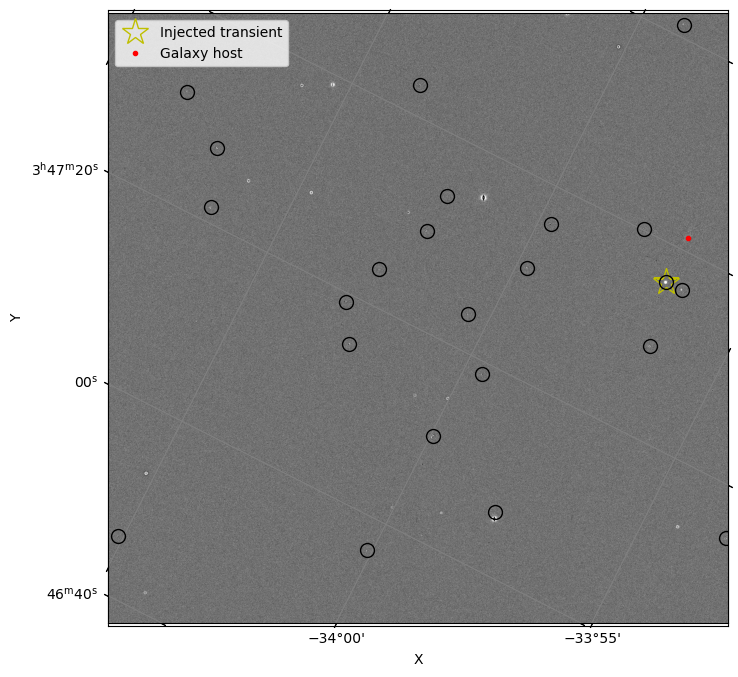

In [21]:
# plots the image difference with overlayed reconstructed sources
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.subplot(projection=img_wcs)
plt.imshow(image_data, cmap='gray', **limits)
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
for _, source in diaSources_df.iterrows():
    coord_source = SkyCoord(
        ra = source["coord_ra"] * u.deg,
        dec = source["coord_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10)

limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

### Anomalies filtering

The goal of this section is to clean the output of `detectAndMeasure`, filtering out anomalous sources which could originate from star sources, or other image artifact.

Let's take a look at the masks that come with calexp. We will define two functions, one for getting a mask plane and another for getting the mask keyword bit at a sky coordinate.

In [52]:
def get_mask(calexp, mask_name: str) -> np.ndarray:
    mask = calexp.getMask()
    target_bit = mask.getMaskPlane(mask_name)
    mask_array = mask.getArray()
    return (mask_array & (2 ** target_bit)) != 0

def get_mask_coord(calexp, ra, dec) -> list[str]:
    wcs = WCS(calexp.getWcs().getFitsMetadata())
    coord = SkyCoord(
        ra = ra * u.deg,
        dec = dec * u.deg
    )
    pixel = wcs.world_to_pixel(coord)
    mask = calexp.getMask()
    mask_value = mask[*pixel]
    return [
        keyword 
        for keyword, bit in mask.getMaskPlaneDict().items() 
        if mask_value & (2 ** bit) != 0
    ]    

The mask keywords and bit are stored in a dictionary and are easy to retrieve.

In [53]:
calexp.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CLIPPED': 16,
 'CR': 3,
 'CROSSTALK': 11,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INEXACT_PSF': 17,
 'INJECTED': 14,
 'INJECTED_CORE': 15,
 'INJECTED_CORE_TEMPLATE': 22,
 'INJECTED_TEMPLATE': 21,
 'INTRP': 2,
 'NOT_DEBLENDED': 12,
 'NO_DATA': 8,
 'REJECTED': 18,
 'SAT': 1,
 'SAT_TEMPLATE': 20,
 'SENSOR_EDGE': 19,
 'STREAK': 10,
 'SUSPECT': 7,
 'UNMASKEDNAN': 13,
 'VIGNETTED': 9}

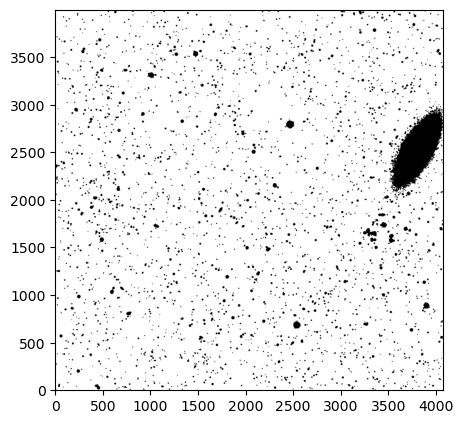

In [54]:
plt.figure(figsize=(5,5))
plt.imshow(get_mask(calexp, "DETECTED"), cmap="binary", origin='lower')
plt.show()

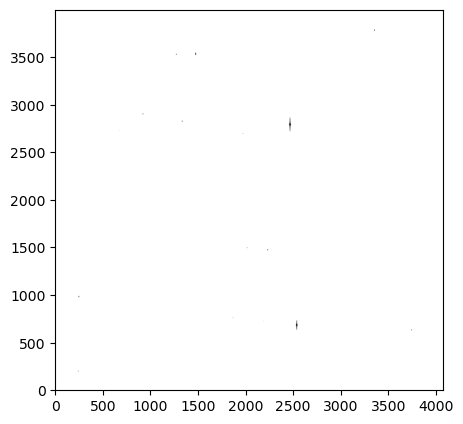

In [146]:
plt.figure(figsize=(5,5))
plt.imshow(get_mask(calexp, "SAT"), cmap="binary", origin='lower')
plt.show()

It's easy to see that some of our anomalies falls in region with meaningful mask value. For example, the brightest detected source has centroid marked with flags for "DETECTED", "INTRP", "SAT".

In [55]:
source = diaSources_df.sort_values("snr_base").iloc[0]
get_mask_coord(calexp, source["coord_ra"], source["coord_dec"])

['DETECTED', 'INTRP', 'SAT']

Let's annotate the dataframe to mark sources with their mask flags.

In [84]:
def insert_mask_keywords(anomalies: pd.DataFrame) -> pd.DataFrame:
    # not in-place
    keywords: list[list[str]] = [get_mask_coord(calexp, ra, dec) for ra, dec in anomalies[["coord_ra", "coord_dec"]].values]
    return pd.concat(
        (anomalies,
        pd.DataFrame({
                f"mask_{k}": [1 if k in ks else 0 for ks in keywords ]
                for k in set([k for ks in keywords for k in ks])
        })),
        axis=1,
    )

diaSources_df_ = insert_mask_keywords(diaSources_df)
diaSources_df_.sort_values("mask_SAT", ascending=False).head()

,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base,mag_base,mag_base_errBot,mag_base_errTop,mask_DETECTED,mask_INTRP,mask_SAT,mask_NOT_DEBLENDED
22,57.005326,-33.984971,3.002625e+03,683.277572,2.352299e+05,672.816407,349.619731,4.394444,18.751311,23.263683,23.766628,1,1,1,0
7,56.813602,-34.041535,-2.978634e+03,1664.598995,1.249856e+06,1644.519224,760.013158,-1.789400,16.937892,NaN,NaN,1,1,1,0
11,56.900636,-33.948517,1.178504e+06,1584.213702,1.185265e+06,1586.573141,747.059760,743.904900,16.995504,17.000256,17.003175,1,0,0,0
19,56.864645,-34.116765,2.862454e+04,2062.770567,1.932008e+06,2039.673386,947.214296,13.876746,16.465020,20.962645,21.119400,1,0,0,0
0,56.735974,-34.001814,6.502495e+03,697.263449,2.124574e+05,691.254442,307.350570,9.325736,18.861862,22.536748,22.770494,1,0,0,1


Now we can filter out sources with bad mask values:

Unfortunately we cannot simply rely on the `DETECTED` mask value for removing anomalies with no known counterparts: the source could be overimposed to an extended objects (e.g., a galaxy). To catch these kind of anomalies we shall first compare their position against that of catalogue stars.

In [85]:
def drop_bad_mask(anomalies, keywords: list[str]):
    mask_cols = [f"mask_{k}" for k in keywords if f"mask_{k}" in anomalies.columns]
    if not mask_cols:
        return anomalies.copy()
    rows_to_drop = (anomalies[mask_cols] == 1).any(axis=1)
    return anomalies[~rows_to_drop]

before_cut = len(diaSources_df_)
bad_keywords = ["SAT", "CROSSTALK", "CR", "BAD", "STREAK", ]
diaSources_df__ = drop_bad_mask(diaSources_df_, bad_keywords)
after_cut = len(diaSources_df__)
print(f"Removed {before_cut - after_cut} sources")
diaSources_df__.sort_values("mask_SAT", ascending=False).head()

Removed 2 sources


,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base,mag_base,mag_base_errBot,mag_base_errTop,mask_DETECTED,mask_INTRP,mask_SAT,mask_NOT_DEBLENDED
11,56.900636,-33.948517,1.178504e+06,1584.213702,1.185265e+06,1586.573141,747.059760,743.904900,16.995504,17.000256,17.003175,1,0,0,0
13,56.878835,-33.995991,8.855178e+04,2130.106379,2.065068e+06,2110.593033,978.430056,41.571530,16.392707,19.786241,19.838486,1,0,0,0
10,56.900941,-33.942121,8.397084e+04,2203.335160,2.173672e+06,2181.495015,996.414082,38.110789,16.337057,19.841599,19.898590,1,0,0,0
19,56.864645,-34.116765,2.862454e+04,2062.770567,1.932008e+06,2039.673386,947.214296,13.876746,16.465020,20.962645,21.119400,1,0,0,0
0,56.735974,-34.001814,6.502495e+03,697.263449,2.124574e+05,691.254442,307.350570,9.325736,18.861862,22.536748,22.770494,1,0,0,1


In [117]:
s_region = "POLYGON ICRS 56.772371 -33.853414 56.633431 -34.079736 56.902664 -34.193001 57.041067 -33.966365"
query = ("SELECT mt.id_truth_type AS mt_id_truth_type, "
        "mt.match_objectId AS mt_match_objectId, "
        "ts.ra AS ts_ra, "
        "ts.dec AS ts_dec, "
        "ts.mag_r AS ts_mag_r, "
        "ts.redshift AS ts_redshift, "
        "ts.flux_r AS ts_flux_r, "
        "obj.coord_ra AS obj_coord_ra, "
        "obj.coord_dec AS obj_coord_dec, "
        "obj.refExtendedness AS obj_refExtendedness, "
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "
        "obj.r_cModelFlux AS obj_r_cModelFlux "
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "
        "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), POLYGON('ICRS', 56.772371, -33.853414, 56.633431, -34.079736, 56.902664, -34.193001, 57.041067, -33.966365)) = 1 "
        "AND ts.truth_type = 2 "  # stars have type 2
        "AND obj.detect_isPrimary = 1 ")

stars_true_df = query_and_table(service, query).to_pandas()

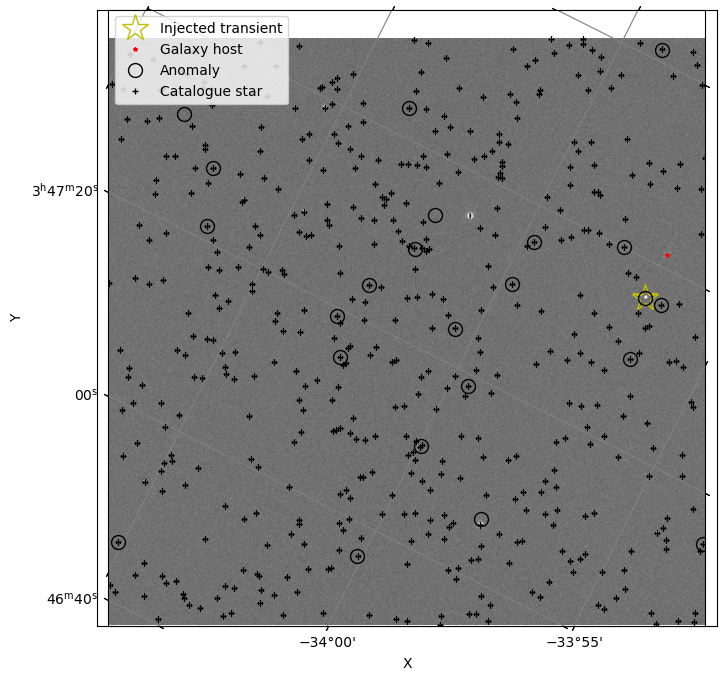

In [118]:
# plots the image difference with overlayed sources and catalog stars
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.subplot(projection=img_wcs)
plt.imshow(image_data, cmap='gray', **limits)
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'r*', ms=3, label="Galaxy host")

printed_label = False
for _, source in diaSources_df.iterrows():
    coord_source = SkyCoord(
        ra = source["coord_ra"] * u.deg,
        dec = source["coord_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10, label="Anomaly" if not printed_label else "")
    printed_label = True
    
printed_label = False
for _, star in stars_true_df.iterrows():
    if not calexp.containsSkyCoords(star["ts_ra"] * u.deg, star["ts_dec"] * u.deg):
        continue
    coord_source = SkyCoord(
        ra = star["ts_ra"] * u.deg,
        dec = star["ts_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'k+', markerfacecolor="None", ms=5, label="Catalogue star" if not printed_label else "")
    printed_label = True
    
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend(loc = "upper left")
plt.show()

In [144]:
def filter_unmatched_sources(
    anomalies: pd.DataFrame,
    catalog: pd.DataFrame,
    tolerance_arcsec: float = 0.2, # pixel size
) -> pd.DataFrame:
    source_coords = anomalies[["coord_ra", "coord_dec"]].values
    ref_coords = catalog[["obj_coord_ra", "obj_coord_dec"]].values
    tolerance_deg = tolerance_arcsec / 3600.0
    diffs = source_coords[:, np.newaxis, :] - ref_coords[np.newaxis, :, :]
    is_match = np.any(
        (np.abs(diffs[:, :, 0]) < tolerance_deg) &
        (np.abs(diffs[:, :, 1]) < tolerance_deg),
        axis=1
    )
    return anomalies[~is_match]

diaSources_df___ = filter_unmatched_sources(diaSources_df__, stars_true_df)

In [145]:
diaSources_df___

,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base,mag_base,mag_base_errBot,mag_base_errTop,mask_DETECTED,mask_INTRP,mask_SAT,mask_NOT_DEBLENDED
11,56.900636,-33.948517,1.178504e+06,1584.213702,1.185265e+06,1586.573141,747.059760,743.904900,16.995504,17.000256,17.003175,1,0,0,0
0,56.735974,-34.001814,6.502495e+03,697.263449,2.124574e+05,691.254442,307.350570,9.325736,18.861862,22.536748,22.770494,1,0,0,1
20,56.880746,-34.135867,2.311121e+03,250.189089,4.991528e+03,247.968260,20.129707,9.237498,22.934458,23.658887,23.894883,1,0,0,0
18,56.891068,-34.033815,1.221150e+03,235.701101,1.205338e+03,232.321372,5.188237,5.180926,24.477270,24.271504,24.695957,1,0,0,0
3,56.776472,-33.966500,1.195567e+03,235.841332,1.473513e+03,234.013496,6.296702,5.069371,24.259157,24.290633,24.724674,1,0,0,0
8,56.848849,-34.007802,2.099256e+03,420.567637,6.366638e+04,415.907047,153.078399,4.991482,20.170267,23.676617,24.117617,1,0,0,0
14,56.873320,-34.034913,3.706454e+03,747.288975,3.261556e+05,740.897716,440.216714,4.959867,18.396480,23.058229,23.502119,1,0,0,0
4,56.794173,-33.999089,8.024082e+02,266.387510,2.706309e+04,263.492992,102.708974,3.012184,21.099099,24.607806,25.357089,1,0,0,0


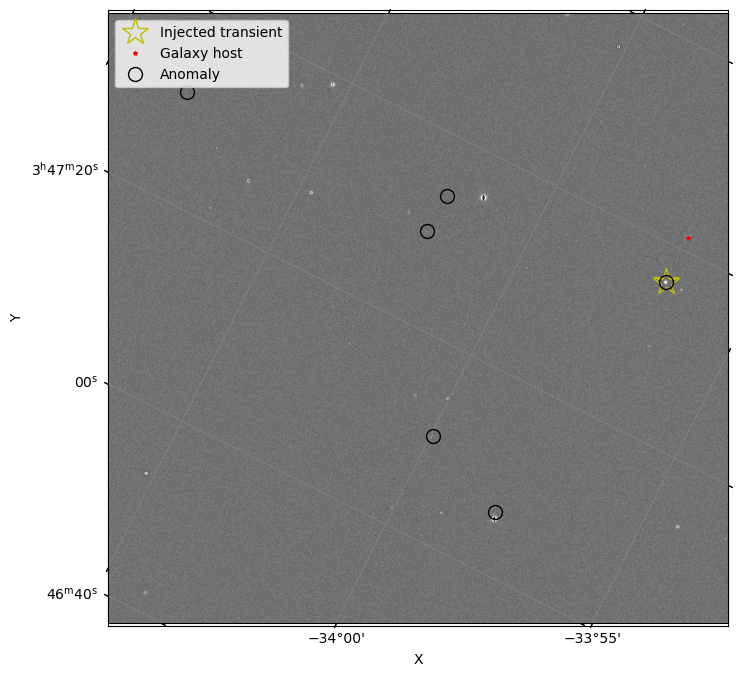

In [143]:
# plots the image difference with overlayed sources and catalog stars
df = diaSources_df___
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.subplot(projection=img_wcs)
plt.imshow(image_data, cmap='gray', **limits)
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'r*', ms=3, label="Galaxy host")

printed_label = False
for _, source in df.iterrows():
    coord_source = SkyCoord(
        ra = source["coord_ra"] * u.deg,
        dec = source["coord_dec"] * u.deg,
        frame='icrs'
    )
    plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10, label="Anomaly" if not printed_label else "")
    printed_label = True
    
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend(loc = "upper left")
plt.show()

We have much reduced our anomalies dataset but we did not succeed in retrieving _only_ our injected source. What other filter can we devise? Maybe we could check of overlap with an extended, galactic object? Could be doable.